# Statistical Testing for Staffing Configuration Evaluation

## Purpose
This notebook provides clean, reusable functions for statistical analysis of simulation results.

## Key Concepts

**Pilot Study**: A small preliminary run (n₀ ≈ 30 replications) to estimate variance before the full study.
- Problem: To calculate required replications, we need σ (standard deviation)
- Solution: Run a small pilot to estimate σ̂, then use it to calculate n

**Confidence Interval Formula** (using t-distribution):
$$\hat{\mu}_n \pm t_{1-\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}$$

**Required Replications** (for target relative error γ):
$$n \geq \left(\frac{t_{1-\alpha/2} \cdot CV}{\gamma}\right)^2$$
where CV = σ/μ (coefficient of variation)


In [17]:
"""Statistical testing functions for simulation analysis."""

import numpy as np
from scipy import stats
from dataclasses import replace
from typing import Dict, List, Optional, Tuple
from itertools import product
from multiprocessing import Pool

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

from parameters import SingleDishParameters
from runner import run_single_dish_sim
from dish_loading import load_recipes_from_json


In [18]:
def run_replications(params: SingleDishParameters, 
                     n: int, 
                     metric: str = 'net_revpash',
                     base_seed: int = 1000) -> np.ndarray:
    """
    Run n independent replications of simulation.
    
    Args:
        params: Base simulation parameters
        n: Number of replications to run
        metric: Result metric to collect (default: 'net_revpash')
        base_seed: Base seed value (uses base_seed + rep for each replication)
    
    Returns:
        1D numpy array of n metric values
    """
    if n <= 0:
        raise ValueError("n must be positive")
    
    results = []
    for rep in range(n):
        # Create copy with unique seed for this replication
        params_rep = replace(params, seed=base_seed + rep)
        result = run_single_dish_sim(params_rep, verbose=False)
        results.append(result.get(metric, 0.0))
    
    return np.array(results)


In [19]:
def compute_ci(samples: np.ndarray, confidence: float = 0.95) -> Dict[str, float]:
    """
    Compute confidence interval from samples using t-distribution.
    
    Args:
        samples: Array of sample observations
        confidence: Confidence level (default 0.95 for 95% CI)
    
    Returns:
        Dictionary with:
        - 'mean': sample mean
        - 'std': sample standard deviation
        - 'ci_lower': lower bound of CI
        - 'ci_upper': upper bound of CI
        - 'half_width': absolute CI half-width
        - 'half_width_rel': relative CI half-width (half_width / |mean|)
        - 'n': sample size
    """
    if len(samples) == 0:
        raise ValueError("samples cannot be empty")
    if not 0 < confidence < 1:
        raise ValueError("confidence must be between 0 and 1")
    
    n = len(samples)
    mean = np.mean(samples)
    std = np.std(samples, ddof=1)  # Sample std with Bessel's correction
    
    # Handle edge case: single sample
    if n == 1:
        return {
            'mean': mean,
            'std': 0.0,
            'ci_lower': mean,
            'ci_upper': mean,
            'half_width': 0.0,
            'half_width_rel': 0.0,
            'n': n
        }
    
    alpha = 1 - confidence
    t_critical = stats.t.ppf(1 - alpha/2, df=n - 1)
    
    se = std / np.sqrt(n)  # Standard error
    half_width = t_critical * se
    
    # Relative half-width (handle zero mean)
    half_width_rel = half_width / abs(mean) if abs(mean) > 1e-10 else np.inf
    
    return {
        'mean': mean,
        'std': std,
        'ci_lower': mean - half_width,
        'ci_upper': mean + half_width,
        'half_width': half_width,
        'half_width_rel': half_width_rel,
        'n': n
    }


In [20]:
def estimate_n_required(pilot_samples: np.ndarray,
                        target_relative_error: float = 0.05,
                        confidence: float = 0.95) -> Dict[str, float]:
    """
    Estimate required number of replications for target relative error.
    
    Uses iterative t-distribution formula: n >= (t * CV / rel_error)^2
    
    Args:
        pilot_samples: Array of n₀ pilot observations
        target_relative_error: Target relative CI half-width (e.g., 0.05 = 5%)
        confidence: Confidence level (default 0.95)
    
    Returns:
        Dictionary with:
        - 'n_pilot': number of pilot samples
        - 'n_required': estimated required replications
        - 'mean': sample mean from pilot
        - 'std': sample standard deviation from pilot
        - 'cv': coefficient of variation (std/mean)
        - 'target_relative_error': the target we're solving for
        - 'expected_relative_error': expected error if we use n_required
    """
    if len(pilot_samples) < 2:
        raise ValueError("Need at least 2 pilot samples")
    if not 0 < target_relative_error < 1:
        raise ValueError("target_relative_error must be between 0 and 1")
    if not 0 < confidence < 1:
        raise ValueError("confidence must be between 0 and 1")
    
    n_pilot = len(pilot_samples)
    mean = np.mean(pilot_samples)
    std = np.std(pilot_samples, ddof=1)
    
    # Coefficient of variation
    cv = std / abs(mean) if abs(mean) > 1e-10 else np.inf
    
    alpha = 1 - confidence
    
    # Iterative calculation with t-distribution
    # Start with initial estimate based on z-distribution
    z_critical = stats.norm.ppf(1 - alpha/2)
    n_estimate = max(2, int(np.ceil((z_critical * cv / target_relative_error) ** 2)))
    
    # Iterate to refine with t-distribution (converges quickly)
    for _ in range(10):
        t_critical = stats.t.ppf(1 - alpha/2, df=n_estimate - 1)
        n_new = max(2, int(np.ceil((t_critical * cv / target_relative_error) ** 2)))
        
        if n_new == n_estimate:
            break
        n_estimate = n_new
    
    # Calculate expected relative error with n_estimate
    if n_estimate >= 2:
        t_final = stats.t.ppf(1 - alpha/2, df=n_estimate - 1)
        expected_rel_error = t_final * cv / np.sqrt(n_estimate)
    else:
        expected_rel_error = np.inf
    
    return {
        'n_pilot': n_pilot,
        'n_required': n_estimate,
        'mean': mean,
        'std': std,
        'cv': cv,
        'target_relative_error': target_relative_error,
        'expected_relative_error': expected_rel_error
    }


In [21]:
def run_pilot_study(configs: List[SingleDishParameters],
                    n_pilot: int = 30,
                    metric: str = 'net_revpash',
                    target_relative_error: float = 0.05,
                    base_seed: int = 1000) -> Dict[int, Dict]:
    """
    Run pilot study on multiple configurations.
    
    Args:
        configs: List of SingleDishParameters configurations
        n_pilot: Number of replications per configuration (default 30)
        metric: Result metric to collect (default: 'net_revpash')
        target_relative_error: Target relative error for n estimation
        base_seed: Base seed (each config gets base_seed + config_idx * 1000)
    
    Returns:
        Dictionary mapping config_index to:
        {
            'samples': array of metric values,
            'ci': confidence interval dict from compute_ci(),
            'n_estimate': dict from estimate_n_required(),
            'config': the SingleDishParameters used
        }
    """
    if not configs:
        raise ValueError("configs list cannot be empty")
    if n_pilot < 2:
        raise ValueError("n_pilot must be at least 2")
    
    results = {}
    total_configs = len(configs)
    
    print(f"Running pilot study: {total_configs} configs × {n_pilot} replications")
    print("=" * 60)
    
    for idx, config in enumerate(configs):
        # Use different seed range for each config
        config_base_seed = base_seed + idx * 1000
        
        # Run replications
        samples = run_replications(config, n_pilot, metric, config_base_seed)
        
        # Compute CI
        ci = compute_ci(samples)
        
        # Estimate required n
        n_est = estimate_n_required(samples, target_relative_error)
        
        results[idx] = {
            'samples': samples,
            'ci': ci,
            'n_estimate': n_est,
            'config': config
        }
        
        # Progress report
        print(f"Config {idx + 1}/{total_configs}: "
              f"mean={ci['mean']:.2f}, "
              f"CI=[{ci['ci_lower']:.2f}, {ci['ci_upper']:.2f}], "
              f"n_required={n_est['n_required']}")
    
    print("=" * 60)
    print(f"Pilot study complete.")
    
    return results


In [22]:
def run_to_target_precision(params: SingleDishParameters,
                            pilot_samples: np.ndarray,
                            metric: str = 'net_revpash',
                            target_relative_error: float = 0.05,
                            confidence: float = 0.95,
                            base_seed: int = 1000,
                            max_iterations: int = 5,
                            min_batch_size: int = 10) -> Dict:
    """
    Run additional replications until target precision is achieved.
    
    Starts with pilot samples, estimates required n, runs additional replications,
    and iteratively continues until target relative error is met.
    
    Args:
        params: Simulation parameters
        pilot_samples: Array of pilot observations (will be combined with new samples)
        metric: Result metric to collect (default: 'net_revpash')
        target_relative_error: Target relative CI half-width (e.g., 0.05 = 5%)
        confidence: Confidence level (default 0.95)
        base_seed: Base seed (new replications start from base_seed + len(pilot_samples))
        max_iterations: Maximum number of iterations to avoid infinite loops
        min_batch_size: Minimum additional replications to run per iteration
    
    Returns:
        Dictionary with:
        - 'all_samples': combined array of all samples
        - 'ci': final confidence interval dict
        - 'n_required': final estimated n_required
        - 'iterations': number of iterations performed
        - 'converged': whether target was achieved
        - 'history': list of (n, rel_error) tuples for each iteration
    """
    if len(pilot_samples) < 2:
        raise ValueError("Need at least 2 pilot samples")
    
    all_samples = pilot_samples.copy()
    current_seed = base_seed + len(pilot_samples)
    history = []
    iterations = 0
    
    print(f"Running to target precision: {target_relative_error*100:.1f}% relative error")
    print(f"Starting with {len(pilot_samples)} pilot samples")
    print("=" * 60)
    
    while iterations < max_iterations:
        iterations += 1
        
        # Compute current CI
        ci = compute_ci(all_samples, confidence)
        current_rel_error = ci['half_width_rel']
        
        history.append((len(all_samples), current_rel_error))
        
        print(f"Iteration {iterations}: n={len(all_samples)}, "
              f"mean={ci['mean']:.2f}, "
              f"rel_error={current_rel_error*100:.2f}%")
        
        # Check if target achieved
        if current_rel_error <= target_relative_error:
            print(f"✓ Target achieved! Relative error ≤ {target_relative_error*100:.1f}%")
            print("=" * 60)
            break
        
        # Estimate how many more we need
        n_est = estimate_n_required(all_samples, target_relative_error, confidence)
        n_required = n_est['n_required']
        current_n = len(all_samples)
        
        if n_required <= current_n:
            # We have enough, but precision not achieved yet
            # Run a small batch and check again
            additional_n = max(min_batch_size, current_n // 4)
        else:
            # Run enough to reach estimated requirement (or min batch)
            additional_n = max(min_batch_size, n_required - current_n)
        
        print(f"  Estimated n_required: {n_required}, running {additional_n} more replications...")
        
        # Run additional replications
        new_samples = run_replications(
            params, 
            n=additional_n, 
            metric=metric,
            base_seed=current_seed
        )
        
        # Combine with existing samples
        all_samples = np.concatenate([all_samples, new_samples])
        current_seed += additional_n
    
    # Final results
    final_ci = compute_ci(all_samples, confidence)
    final_n_est = estimate_n_required(all_samples, target_relative_error, confidence)
    
    converged = final_ci['half_width_rel'] <= target_relative_error
    
    if not converged and iterations >= max_iterations:
        print(f"⚠ Max iterations ({max_iterations}) reached. "
              f"Current relative error: {final_ci['half_width_rel']*100:.2f}%")
        print("=" * 60)
    
    return {
        'all_samples': all_samples,
        'ci': final_ci,
        'n_estimate': final_n_est,
        'iterations': iterations,
        'converged': converged,
        'history': history
    }

In [23]:
def generate_configuration_grid(base_params: SingleDishParameters,
                                 server_range: List[int],
                                 cook_range: List[int],
                                 host_range: List[int] = [1],
                                 food_runner_range: List[int] = [2],
                                 busser_range: List[int] = [0]) -> List[SingleDishParameters]:
    """
    Generate systematic grid of configurations by varying ALL staffing parameters.
    
    Args:
        base_params: Base parameters (will copy dish_recipes, menu, etc.)
        server_range: List of server counts to test (e.g., [4, 5, 6, 7, 8])
        cook_range: List of cook counts to test (e.g., [6, 7, 8, 9, 10])
        host_range: List of host counts to test (e.g., [1, 2])
        food_runner_range: List of food runner counts (e.g., [1, 2, 3])
        busser_range: List of busser counts (e.g., [0, 1, 2])
    
    Returns:
        List of SingleDishParameters configurations (Cartesian product of all ranges)
    
    Warning:
        Total configs = len(server_range) × len(cook_range) × len(host_range) × 
                        len(food_runner_range) × len(busser_range)
        Can be very large! Consider using smaller ranges or screening.
    """
    # Calculate total combinations
    total = (len(server_range) * len(cook_range) * len(host_range) * 
             len(food_runner_range) * len(busser_range))
    
    print(f"Generating configuration grid:")
    print(f"  Servers: {server_range} ({len(server_range)} values)")
    print(f"  Cooks: {cook_range} ({len(cook_range)} values)")
    print(f"  Hosts: {host_range} ({len(host_range)} values)")
    print(f"  Food Runners: {food_runner_range} ({len(food_runner_range)} values)")
    print(f"  Bussers: {busser_range} ({len(busser_range)} values)")
    print(f"  Total configurations: {total}")
    
    if total > 100:
        print(f"  ⚠ Warning: Large number of configurations! Consider screening or smaller ranges.")
    
    configs = []
    for servers, cooks, hosts, runners, bussers in product(
        server_range, cook_range, host_range, food_runner_range, busser_range
    ):
        config = replace(
            base_params,
            num_servers=servers,
            num_cooks=cooks,
            num_hosts=hosts,
            num_food_runners=runners,
            num_bussers=bussers
        )
        configs.append(config)
    
    return configs


def config_to_label(config: SingleDishParameters) -> str:
    """Generate a short label for a configuration."""
    return (f"S{config.num_servers}_C{config.num_cooks}_H{config.num_hosts}_"
            f"R{config.num_food_runners}_B{config.num_bussers}")


In [24]:
def compare_configurations_pairwise(samples_A: np.ndarray,
                                     samples_B: np.ndarray,
                                     confidence: float = 0.95) -> Dict:
    """
    Compare two configurations using confidence interval for the difference.
    
    Uses Welch's t-test (doesn't assume equal variances or sample sizes).
    
    Args:
        samples_A: Array of sample observations from configuration A
        samples_B: Array of sample observations from configuration B
        confidence: Confidence level (default 0.95)
    
    Returns:
        Dictionary with:
        - 'mean_A': mean of samples A
        - 'mean_B': mean of samples B
        - 'mean_diff': mean difference (A - B)
        - 'ci_lower': lower bound of CI for difference
        - 'ci_upper': upper bound of CI for difference
        - 'significant': True if CI doesn't contain zero (statistically different)
        - 'A_better': True if A is significantly better than B (mean_diff > 0 and significant)
        - 'B_better': True if B is significantly better than A (mean_diff < 0 and significant)
        - 'n_A': sample size A
        - 'n_B': sample size B
    """
    if len(samples_A) < 2 or len(samples_B) < 2:
        raise ValueError("Need at least 2 samples from each configuration")
    if not 0 < confidence < 1:
        raise ValueError("confidence must be between 0 and 1")
    
    n_A = len(samples_A)
    n_B = len(samples_B)
    mean_A = np.mean(samples_A)
    mean_B = np.mean(samples_B)
    var_A = np.var(samples_A, ddof=1)
    var_B = np.var(samples_B, ddof=1)
    
    mean_diff = mean_A - mean_B
    
    # Welch's t-test (unequal variances)
    # Standard error of the difference
    se_diff = np.sqrt(var_A / n_A + var_B / n_B)
    
    # Welch-Satterthwaite degrees of freedom
    if se_diff > 0:
        df_num = (var_A / n_A + var_B / n_B) ** 2
        df_denom = ((var_A / n_A) ** 2 / (n_A - 1) + 
                    (var_B / n_B) ** 2 / (n_B - 1))
        df = df_num / df_denom if df_denom > 0 else min(n_A, n_B) - 1
    else:
        df = min(n_A, n_B) - 1
    
    alpha = 1 - confidence
    t_critical = stats.t.ppf(1 - alpha/2, df=df)
    
    half_width = t_critical * se_diff
    ci_lower = mean_diff - half_width
    ci_upper = mean_diff + half_width
    
    # Significance: CI doesn't contain zero
    significant = not (ci_lower <= 0 <= ci_upper)
    
    return {
        'mean_A': mean_A,
        'mean_B': mean_B,
        'mean_diff': mean_diff,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'half_width': half_width,
        'significant': significant,
        'A_better': significant and mean_diff > 0,
        'B_better': significant and mean_diff < 0,
        'n_A': n_A,
        'n_B': n_B,
        'df': df
    }


In [25]:
def subset_selection(screening_results: Dict[int, Dict],
                     confidence: float = 0.95,
                     metric_key: str = 'ci') -> Dict:
    """
    Screen configurations to find "may be the best" subset.
    
    Uses one-sided confidence intervals with Bonferroni correction for
    multiple comparisons. A config is kept if it could potentially be the best.
    
    Args:
        screening_results: Dictionary from run_pilot_study or screening:
            {idx: {'samples': array, 'ci': {...}, 'config': SingleDishParameters}}
        confidence: Confidence level (default 0.95)
        metric_key: Key to access CI dict (default 'ci')
    
    Returns:
        Dictionary with:
        - 'best_idx': index of sample best configuration
        - 'best_mean': mean of best configuration
        - 'may_be_best': list of indices that could potentially be the best
        - 'not_best': list of indices that are statistically inferior
        - 'config_stats': dict mapping idx -> (mean, upper_bound)
    """
    if not screening_results:
        raise ValueError("screening_results cannot be empty")
    
    # Find sample best (highest mean - for net_revpash, higher is better)
    best_idx = max(screening_results.keys(), 
                   key=lambda i: screening_results[i][metric_key]['mean'])
    best_mean = screening_results[best_idx][metric_key]['mean']
    
    k = len(screening_results)  # Number of configurations
    alpha = 1 - confidence
    # Bonferroni correction: divide alpha by number of comparisons
    alpha_corrected = alpha / (k - 1) if k > 1 else alpha
    
    may_be_best = [best_idx]  # Best is always included
    not_best = []
    config_stats = {}
    
    for idx, data in screening_results.items():
        ci = data[metric_key]
        mean_i = ci['mean']
        std_i = ci['std']
        n_i = ci['n']
        
        # One-sided upper CI bound: can this config potentially be better than best?
        if n_i > 1:
            t_critical = stats.t.ppf(1 - alpha_corrected, df=n_i - 1)
            upper_bound = mean_i + t_critical * (std_i / np.sqrt(n_i))
        else:
            upper_bound = mean_i
        
        config_stats[idx] = {'mean': mean_i, 'upper_bound': upper_bound}
        
        if idx == best_idx:
            continue
        
        if upper_bound >= best_mean:
            # Could potentially be better
            may_be_best.append(idx)
        else:
            # Statistically inferior
            not_best.append(idx)
    
    # Sort by mean for readability
    may_be_best = sorted(may_be_best, 
                         key=lambda i: screening_results[i][metric_key]['mean'], 
                         reverse=True)
    not_best = sorted(not_best,
                      key=lambda i: screening_results[i][metric_key]['mean'],
                      reverse=True)
    
    print(f"Subset Selection Results (Bonferroni-corrected, α/{k-1 if k>1 else 1}):")
    print(f"  Sample best: Config {best_idx} (mean={best_mean:.3f})")
    print(f"  May be best: {len(may_be_best)} configs ({may_be_best})")
    print(f"  Not best: {len(not_best)} configs (screened out)")
    
    return {
        'best_idx': best_idx,
        'best_mean': best_mean,
        'may_be_best': may_be_best,
        'not_best': not_best,
        'config_stats': config_stats
    }


In [26]:
from typing import Tuple  # <-- FIX: import Tuple for type annotation

# Helper function for parallel execution (must be at module level for pickling)
def _run_single_replication(args: Tuple) -> float:
    """Helper function to run a single replication (for parallel execution)."""
    params, seed, metric = args
    params_rep = replace(params, seed=seed)
    result = run_single_dish_sim(params_rep, verbose=False)
    return result.get(metric, 0.0)


def run_replications_parallel(params: SingleDishParameters,
                              n: int,
                              metric: str = 'net_revpash',
                              base_seed: int = 1000,
                              n_jobs: int = -1) -> np.ndarray:
    """
    Run n replications in parallel using multiprocessing.
    
    Args:
        params: Base simulation parameters
        n: Number of replications to run
        metric: Result metric to collect (default: 'net_revpash')
        base_seed: Base seed value (uses base_seed + rep for each replication)
        n_jobs: Number of parallel workers (-1 = use all CPUs, 1 = sequential)
    
    Returns:
        1D numpy array of n metric values
    """
    if n <= 0:
        raise ValueError("n must be positive")
    
    # Prepare arguments for each replication
    args_list = [(params, base_seed + rep, metric) for rep in range(n)]
    
    if n_jobs == 1:
        # Sequential execution (fallback)
        results = [_run_single_replication(args) for args in args_list]
    else:
        # Parallel execution
        n_workers = None if n_jobs == -1 else n_jobs
        try:
            with Pool(n_workers) as pool:
                results = pool.map(_run_single_replication, args_list)
        except Exception as e:
            print(f"⚠ Parallel execution failed ({e}), falling back to sequential")
            results = [_run_single_replication(args) for args in args_list]
    
    return np.array(results)


def run_screening_parallel(configs: List[SingleDishParameters],
                           n_per_config: int = 10,
                           metric: str = 'net_revpash',
                           base_seed: int = 1000,
                           n_jobs: int = -1) -> Dict[int, Dict]:
    """
    Run quick screening study on all configurations (parallel).
    
    Args:
        configs: List of SingleDishParameters configurations
        n_per_config: Number of replications per configuration (default 10)
        metric: Result metric to collect (default: 'net_revpash')
        base_seed: Base seed (each config gets base_seed + config_idx * 1000)
        n_jobs: Number of parallel workers (-1 = use all CPUs)
    
    Returns:
        Dictionary mapping config_index to:
        {
            'samples': array of metric values,
            'ci': confidence interval dict,
            'config': the SingleDishParameters used
        }
    """
    if not configs:
        raise ValueError("configs list cannot be empty")
    
    total_configs = len(configs)
    total_runs = total_configs * n_per_config
    
    print(f"Screening {total_configs} configurations × {n_per_config} replications = {total_runs} total runs")
    print("=" * 60)
    
    results = {}
    for idx, config in enumerate(configs):
        # Use different seed range for each config
        config_base_seed = base_seed + idx * 1000
        
        # Run replications (sequential for now to avoid nested parallelism issues)
        # Each config runs sequentially but we process configs one at a time
        samples = run_replications(config, n_per_config, metric, config_base_seed)
        
        # Compute CI
        ci = compute_ci(samples)
        
        results[idx] = {
            'samples': samples,
            'ci': ci,
            'config': config
        }
        
        # Progress report
        label = config_to_label(config)
        print(f"[{idx+1}/{total_configs}] {label}: mean={ci['mean']:.2f}, "
              f"CI=[{ci['ci_lower']:.2f}, {ci['ci_upper']:.2f}]")
    
    print("=" * 60)
    print(f"Screening complete.")
    
    return results


In [39]:
# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def plot_configuration_grid(configs: List[SingleDishParameters],
                            server_range: List[int],
                            cook_range: List[int],
                            host_range: List[int],
                            food_runner_range: List[int],
                            busser_range: List[int]):
    """
    Visualize the configuration grid showing parameter ranges and total count.
    """
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # Plot 1: Parameter ranges as bar chart
    ax1 = axes[0]
    params = ['Servers', 'Cooks', 'Hosts', 'Food Runners', 'Bussers']
    ranges = [server_range, cook_range, host_range, food_runner_range, busser_range]
    counts = [len(r) for r in ranges]
    colors = sns.color_palette("husl", len(params))
    
    bars = ax1.bar(params, counts, color=colors, edgecolor='black', linewidth=1.2)
    ax1.set_ylabel('Number of Values', fontsize=11)
    ax1.set_title('Parameter Variations', fontsize=12, fontweight='bold')
    ax1.set_ylim(0, max(counts) + 1)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax1.tick_params(axis='x', rotation=30)
    
    # Plot 2: Range details as text table
    ax2 = axes[1]
    ax2.axis('off')
    table_data = []
    for name, rng in zip(params, ranges):
        table_data.append([name, f"{min(rng)} - {max(rng)}", str(len(rng))])
    
    table = ax2.table(cellText=table_data,
                      colLabels=['Parameter', 'Range', 'Count'],
                      loc='center',
                      cellLoc='center',
                      colColours=['#E8E8E8']*3)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax2.set_title('Configuration Ranges', fontsize=12, fontweight='bold', pad=20)
    
    # Plot 3: Total configurations breakdown
    ax3 = axes[2]
    total = len(configs)
    breakdown = ' × '.join([str(c) for c in counts])
    
    ax3.text(0.5, 0.6, f'{total}', fontsize=48, fontweight='bold', 
             ha='center', va='center', color='#2E86AB')
    ax3.text(0.5, 0.35, 'Total Configurations', fontsize=14, ha='center', va='center')
    ax3.text(0.5, 0.2, f'({breakdown})', fontsize=11, ha='center', va='center', color='gray')
    ax3.axis('off')
    ax3.set_title('Grid Size', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


def plot_screening_results(screening_results: Dict[int, Dict], top_n: int = 30):
    """
    Visualize screening results with multiple plots.
    """
    # Extract data
    indices = list(screening_results.keys())
    means = [screening_results[i]['ci']['mean'] for i in indices]
    half_widths = [screening_results[i]['ci']['half_width'] for i in indices]
    labels = [config_to_label(screening_results[i]['config']) for i in indices]
    
    # Sort by mean (descending)
    sorted_data = sorted(zip(indices, means, half_widths, labels), 
                         key=lambda x: x[1], reverse=True)
    
    # Take top_n for detailed view
    top_data = sorted_data[:top_n]
    top_indices, top_means, top_hws, top_labels = zip(*top_data) if top_data else ([], [], [], [])
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Top N configurations with error bars
    ax1 = axes[0, 0]
    y_pos = np.arange(len(top_means))
    colors = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(top_means)))
    
    ax1.barh(y_pos, top_means, xerr=top_hws, color=colors, 
             edgecolor='black', linewidth=0.5, capsize=3)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_labels, fontsize=8)
    ax1.set_xlabel('Net RevPASH (mean ± CI half-width)', fontsize=10)
    ax1.set_title(f'Top {len(top_means)} Configurations by Mean', fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    
    # Plot 2: Distribution of all means (histogram)
    ax2 = axes[0, 1]
    ax2.hist(means, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax2.axvline(x=np.mean(means), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(means):.2f}')
    ax2.axvline(x=np.max(means), color='green', linestyle='--', linewidth=2,
                label=f'Max: {np.max(means):.2f}')
    ax2.set_xlabel('Net RevPASH', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.set_title('Distribution of Configuration Means', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    
    # Plot 3: Mean vs CI Width (precision scatter)
    ax3 = axes[1, 0]
    scatter = ax3.scatter(means, half_widths, c=means, cmap='RdYlGn', 
                          s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
    ax3.set_xlabel('Mean Net RevPASH', fontsize=10)
    ax3.set_ylabel('CI Half-Width (uncertainty)', fontsize=10)
    ax3.set_title('Mean vs Uncertainty', fontsize=12, fontweight='bold')
    plt.colorbar(scatter, ax=ax3, label='Mean')
    
    # Highlight best config
    best_idx = np.argmax(means)
    ax3.scatter([means[best_idx]], [half_widths[best_idx]], 
                color='red', s=150, marker='*', zorder=5, label='Best')
    ax3.legend()
    
    # Plot 4: Summary statistics
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    stats_text = f"""
    SCREENING SUMMARY
    ─────────────────────────────
    Total configurations: {len(means)}
    
    Net RevPASH Statistics:
      Mean:   {np.mean(means):.3f}
      Std:    {np.std(means):.3f}
      Min:    {np.min(means):.3f}
      Max:    {np.max(means):.3f}
      Range:  {np.max(means) - np.min(means):.3f}
    
    Best Configuration:
      {labels[best_idx]}
      Mean: {means[best_idx]:.3f}
    
    Positive configs: {sum(1 for m in means if m > 0)} / {len(means)}
    """
    ax4.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
             verticalalignment='center', transform=ax4.transAxes)
    
    plt.tight_layout()
    plt.show()


def plot_subset_selection(screening_results: Dict[int, Dict], 
                          selection: Dict,
                          top_n_display: int = 20):
    """
    Visualize subset selection results showing which configs were kept/screened.
    """
    # Extract data
    indices = list(screening_results.keys())
    means = [screening_results[i]['ci']['mean'] for i in indices]
    half_widths = [screening_results[i]['ci']['half_width'] for i in indices]
    labels = [config_to_label(screening_results[i]['config']) for i in indices]
    
    # Sort by mean
    sorted_data = sorted(zip(indices, means, half_widths, labels), 
                         key=lambda x: x[1], reverse=True)
    
    may_be_best = set(selection['may_be_best'])
    best_idx = selection['best_idx']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Top configs with selection status
    ax1 = axes[0]
    display_data = sorted_data[:top_n_display]
    
    y_pos = np.arange(len(display_data))
    colors = []
    for idx, mean, hw, label in display_data:
        if idx == best_idx:
            colors.append('#FFD700')  # Gold for best
        elif idx in may_be_best:
            colors.append('#90EE90')  # Light green for may-be-best
        else:
            colors.append('#FFB6C1')  # Light red for screened out
    
    bars = ax1.barh(y_pos, [d[1] for d in display_data], 
                    xerr=[d[2] for d in display_data],
                    color=colors, edgecolor='black', linewidth=0.8, capsize=3)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([d[3] for d in display_data], fontsize=8)
    ax1.set_xlabel('Net RevPASH (mean ± CI)', fontsize=10)
    ax1.set_title(f'Top {len(display_data)} Configs: Selection Status', fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FFD700', edgecolor='black', label='Sample Best'),
        Patch(facecolor='#90EE90', edgecolor='black', label='May Be Best'),
        Patch(facecolor='#FFB6C1', edgecolor='black', label='Screened Out')
    ]
    ax1.legend(handles=legend_elements, loc='lower right', fontsize=9)
    
    # Plot 2: Selection summary pie chart and stats
    ax2 = axes[1]
    
    n_may_be_best = len(may_be_best)
    n_screened_out = len(indices) - n_may_be_best
    
    # Pie chart
    sizes = [n_may_be_best, n_screened_out]
    labels_pie = [f'May Be Best\n({n_may_be_best})', f'Screened Out\n({n_screened_out})']
    colors_pie = ['#90EE90', '#FFB6C1']
    explode = (0.05, 0)
    
    ax2.pie(sizes, explode=explode, labels=labels_pie, colors=colors_pie,
            autopct='%1.1f%%', shadow=True, startangle=90,
            textprops={'fontsize': 11})
    ax2.set_title('Subset Selection Results', fontsize=12, fontweight='bold')
    
    # Add text summary below
    reduction = (1 - n_may_be_best / len(indices)) * 100
    summary = f"Reduced search space by {reduction:.1f}%"
    ax2.text(0.5, -0.1, summary, fontsize=11, ha='center', transform=ax2.transAxes,
             fontweight='bold', color='#2E86AB')
    
    plt.tight_layout()
    plt.show()


def plot_precision_convergence(final_results: Dict[int, Dict],
                               screening_results: Dict[int, Dict]):
    """
    Visualize precision study convergence for each promising config.
    """
    n_configs = len(final_results)
    if n_configs == 0:
        print("No final results to plot.")
        return
    
    # Determine subplot layout
    n_cols = min(2, n_configs)
    n_rows = (n_configs + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    if n_configs == 1:
        axes = np.array([axes])
    axes = axes.flatten() if n_configs > 1 else [axes]
    
    for i, (idx, result) in enumerate(final_results.items()):
        ax = axes[i]
        label = config_to_label(screening_results[idx]['config'])
        
        # Get convergence history if available
        history = result.get('history', [])
        if history:
            # History is a list of tuples: (n, rel_error)
            ns = [h[0] for h in history]
            rel_errors = [h[1] * 100 for h in history]
            
            ax.plot(ns, rel_errors, 'bo-', linewidth=2, markersize=8)
            ax.axhline(y=5.0, color='red', linestyle='--', linewidth=2, 
                      label='Target (5%)')
            
            # Shade achieved region
            ax.fill_between([ns[0], ns[-1]], [0, 0], [5, 5], alpha=0.2, color='green')
            
            ax.set_xlabel('Number of Replications', fontsize=10)
            ax.set_ylabel('Relative Error (%)', fontsize=10)
            ax.set_title(f'{label}', fontsize=11, fontweight='bold')
            ax.legend(loc='upper right', fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.set_ylim(0, max(rel_errors) * 1.1)
        else:
            # No iteration history, show final result
            final_ci = result['ci']
            ax.bar([0], [final_ci['half_width_rel']*100], color='steelblue', 
                   edgecolor='black')
            ax.axhline(y=5.0, color='red', linestyle='--', linewidth=2)
            ax.set_ylabel('Relative Error (%)', fontsize=10)
            ax.set_title(f'{label}', fontsize=11, fontweight='bold')
            ax.set_xticks([])
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Precision Convergence per Configuration', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Also show final comparison bar chart
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    
    labels = [config_to_label(screening_results[idx]['config']) for idx in final_results.keys()]
    means = [final_results[idx]['ci']['mean'] for idx in final_results.keys()]
    half_widths = [final_results[idx]['ci']['half_width'] for idx in final_results.keys()]
    n_samples = [len(final_results[idx]['all_samples']) for idx in final_results.keys()]
    
    x = np.arange(len(labels))
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(labels)))
    
    bars = ax2.bar(x, means, yerr=half_widths, color=colors, 
                   edgecolor='black', linewidth=1.2, capsize=5)
    
    # Add sample size labels
    for bar, n in zip(bars, n_samples):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + half_widths[bars.index(bar)] + 0.05,
                f'n={n}', ha='center', va='bottom', fontsize=9)
    
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=30, ha='right', fontsize=9)
    ax2.set_ylabel('Net RevPASH', fontsize=11)
    ax2.set_title('Final Precision Results (Promising Configurations)', fontsize=12, fontweight='bold')
    ax2.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_pairwise_comparisons(final_results: Dict[int, Dict],
                              screening_results: Dict[int, Dict],
                              confidence: float = 0.95):
    """
    Visualize pairwise comparisons with heatmap and CI plots.
    """
    indices = list(final_results.keys())
    n = len(indices)
    
    if n < 2:
        print("Need at least 2 configurations for pairwise comparison.")
        return
    
    labels = [config_to_label(screening_results[idx]['config']) for idx in indices]
    
    # Compute all pairwise differences
    diff_matrix = np.zeros((n, n))
    sig_matrix = np.zeros((n, n))  # 1 if significant, 0 otherwise
    
    for i, idx_i in enumerate(indices):
        for j, idx_j in enumerate(indices):
            if i != j:
                comp = compare_configurations_pairwise(
                    final_results[idx_i]['all_samples'],
                    final_results[idx_j]['all_samples'],
                    confidence=confidence
                )
                diff_matrix[i, j] = comp['mean_diff']
                sig_matrix[i, j] = 1 if comp['significant'] else 0
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Heatmap of differences
    ax1 = axes[0]
    mask = np.eye(n, dtype=bool)
    
    sns.heatmap(diff_matrix, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
                xticklabels=labels, yticklabels=labels, mask=mask,
                ax=ax1, cbar_kws={'label': 'Difference (Row - Col)'},
                linewidths=0.5, linecolor='white')
    
    # Add stars for significant differences
    for i in range(n):
        for j in range(n):
            if i != j and sig_matrix[i, j]:
                ax1.text(j + 0.5, i + 0.75, '*', fontsize=14, 
                        color='black', ha='center', va='center', fontweight='bold')
    
    ax1.set_title('Pairwise Mean Differences\n(* = statistically significant)', 
                  fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', rotation=0)
    
    # Plot 2: CI comparison bars
    ax2 = axes[1]
    
    # Sort by mean
    sorted_indices = sorted(indices, key=lambda i: final_results[i]['ci']['mean'], reverse=True)
    sorted_labels = [config_to_label(screening_results[idx]['config']) for idx in sorted_indices]
    sorted_means = [final_results[idx]['ci']['mean'] for idx in sorted_indices]
    sorted_lowers = [final_results[idx]['ci']['ci_lower'] for idx in sorted_indices]
    sorted_uppers = [final_results[idx]['ci']['ci_upper'] for idx in sorted_indices]
    
    y_pos = np.arange(len(sorted_labels))
    
    # Plot CI ranges as horizontal lines with points
    for i, (mean, lower, upper, label) in enumerate(zip(sorted_means, sorted_lowers, sorted_uppers, sorted_labels)):
        color = plt.cm.viridis(i / len(sorted_labels))
        ax2.hlines(y=i, xmin=lower, xmax=upper, color=color, linewidth=3, alpha=0.7)
        ax2.plot(mean, i, 'o', color=color, markersize=10, markeredgecolor='black')
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(sorted_labels, fontsize=9)
    ax2.set_xlabel('Net RevPASH', fontsize=11)
    ax2.set_title('Final Confidence Intervals (Ranked)', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, axis='x', alpha=0.3)
    
    # Add annotation
    ax2.text(0.02, 0.98, 'Higher is better ↑', transform=ax2.transAxes,
             fontsize=9, verticalalignment='top', style='italic', color='gray')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nPairwise Comparison Summary:")
    print("=" * 50)
    best_idx = sorted_indices[0]
    best_label = config_to_label(screening_results[best_idx]['config'])
    print(f"Best configuration: {best_label}")
    print(f"Mean: {final_results[best_idx]['ci']['mean']:.3f}")
    
    n_sig = int(np.sum(sig_matrix) / 2)  # Each pair counted twice
    print(f"\nSignificant differences found: {n_sig} pairs")
    
    if n_sig == 0:
        print("⚠ No statistically significant differences between top configurations.")
        print("  Consider: running more replications OR accepting they perform similarly.")


## Example: Quick Demonstration

Run a small pilot (10 replications) on default configuration to demonstrate the workflow.


In [28]:
# Quick demonstration: Pilot + Run to Target Precision
# Load Comal recipes
from dish_loading import load_recipes_from_json
params = load_recipes_from_json('comal_recipes.json')

# Step 1: Run pilot study (10 replications)
print("Step 1: Pilot Study")
print("=" * 60)
pilot_samples = run_replications(params, n=10, metric='net_revpash', base_seed=42)
pilot_ci = compute_ci(pilot_samples, confidence=0.95)
pilot_n_est = estimate_n_required(pilot_samples, target_relative_error=0.05)

print(f"Pilot results (n=10):")
print(f"  Mean: {pilot_ci['mean']:.2f}")
print(f"  CI: [{pilot_ci['ci_lower']:.2f}, {pilot_ci['ci_upper']:.2f}]")
print(f"  Relative error: {pilot_ci['half_width_rel']*100:.2f}%")
print(f"  Estimated n_required: {pilot_n_est['n_required']}")
print()

# Step 2: Run to target precision (combines pilot + additional replications)
print("Step 2: Running to Target Precision")
print("=" * 60)
result = run_to_target_precision(
    params=params,
    pilot_samples=pilot_samples,
    metric='net_revpash',
    target_relative_error=0.05,  # 5% target
    confidence=0.95,
    base_seed=42,  # Same base seed (will continue from 42+10=52)
    max_iterations=5
)

print()
print("Final Results:")
print(f"  Total replications: {len(result['all_samples'])}")
print(f"  Mean: {result['ci']['mean']:.2f}")
print(f"  Final CI: [{result['ci']['ci_lower']:.2f}, {result['ci']['ci_upper']:.2f}]")
print(f"  Final relative error: {result['ci']['half_width_rel']*100:.2f}%")
print(f"  Converged: {'✓ Yes' if result['converged'] else '✗ No'}")

Step 1: Pilot Study
Pilot results (n=10):
  Mean: 3.38
  CI: [3.06, 3.71]
  Relative error: 9.58%
  Estimated n_required: 30

Step 2: Running to Target Precision
Running to target precision: 5.0% relative error
Starting with 10 pilot samples
Iteration 1: n=10, mean=3.38, rel_error=9.58%
  Estimated n_required: 30, running 20 more replications...
Iteration 2: n=30, mean=3.19, rel_error=5.76%
  Estimated n_required: 39, running 10 more replications...
Iteration 3: n=40, mean=3.22, rel_error=4.93%
✓ Target achieved! Relative error ≤ 5.0%

Final Results:
  Total replications: 40
  Mean: 3.22
  Final CI: [3.06, 3.38]
  Final relative error: 4.93%
  Converged: ✓ Yes


## Complete Workflow: Multi-Configuration Comparison

Demonstrates the full workflow:
1. Generate configuration grid (all staffing combinations)
2. Run screening study (n=10 per config)
3. Apply subset selection (Bonferroni correction)
4. Run full precision study on promising configs
5. Pairwise comparison of top candidates

**Note**: This example uses small ranges for quick execution. In practice, use larger ranges.


In [29]:
# =============================================================================
# STEP 1: Generate Configuration Grid
# =============================================================================
print("STEP 1: Generate Configuration Grid")
print("=" * 70)

# Load base parameters with Comal recipes
base_params = load_recipes_from_json('comal_recipes.json')

# Define parameter ranges (store as variables for visualization)
# Reduced for ~5-10 minute runtime
server_range = [5, 6, 7]               # 3 values
cook_range = [8, 9, 10]                # 3 values
host_range = [1]                       # 1 value (fixed)
food_runner_range = [1, 2]             # 2 values
busser_range = [0, 1]                     # 1 value (fixed)

# Generate configuration grid
# Total: 3 × 3 × 1 × 2 × 2 = 36 configurations (~3 min for screening)
configs = generate_configuration_grid(
    base_params=base_params,
    server_range=server_range,
    cook_range=cook_range,
    host_range=host_range,
    food_runner_range=food_runner_range,
    busser_range=busser_range
)

print(f"\nGenerated {len(configs)} configurations to evaluate")
print(f"Estimated screening time: ~{len(configs) * 10 * 10 // 60} minutes (n=10 per config)")
print()


STEP 1: Generate Configuration Grid
Generating configuration grid:
  Servers: [5, 6, 7] (3 values)
  Cooks: [8, 9, 10] (3 values)
  Hosts: [1] (1 values)
  Food Runners: [1, 2] (2 values)
  Bussers: [0, 1] (2 values)
  Total configurations: 36

Generated 36 configurations to evaluate
Estimated screening time: ~60 minutes (n=10 per config)



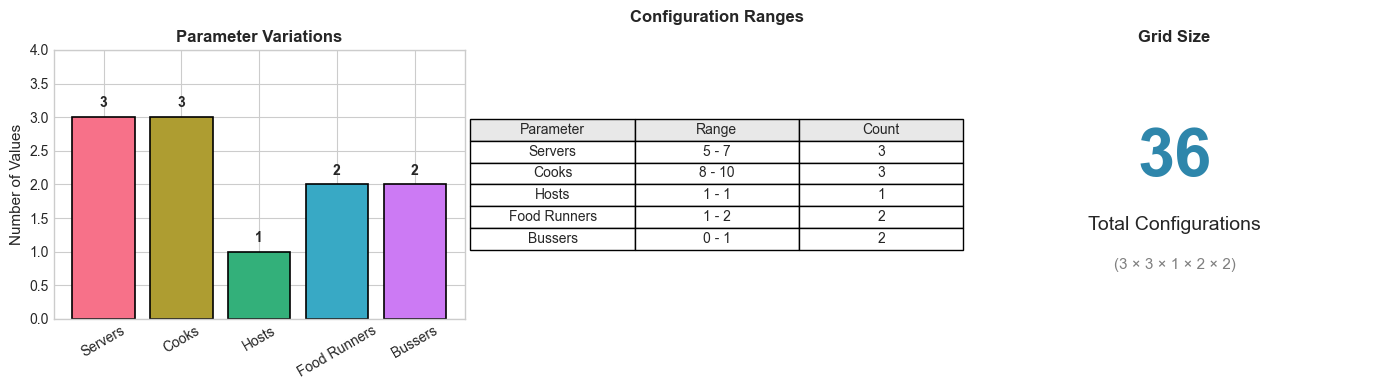

In [30]:
# Visualize the configuration grid
plot_configuration_grid(
    configs=configs,
    server_range=server_range,
    cook_range=cook_range,
    host_range=host_range,
    food_runner_range=food_runner_range,
    busser_range=busser_range
)


In [31]:
# =============================================================================
# STEP 2: Run Screening Study (n=10 per config)
# =============================================================================
print("STEP 2: Run Screening Study")
print("=" * 70)

# Run quick screening (n=10 per config)
screening_results = run_screening_parallel(
    configs=configs,
    n_per_config=10,
    metric='net_revpash',
    base_seed=1000
)

# Display summary
print("\nScreening Summary:")
for idx, data in screening_results.items():
    label = config_to_label(data['config'])
    ci = data['ci']
    print(f"  [{idx}] {label}: mean={ci['mean']:.3f} ± {ci['half_width']:.3f}")
print()


STEP 2: Run Screening Study
Screening 36 configurations × 10 replications = 360 total runs
[1/36] S5_C8_H1_R1_B0: mean=0.65, CI=[0.41, 0.90]
[2/36] S5_C8_H1_R1_B1: mean=0.43, CI=[0.05, 0.82]
[3/36] S5_C8_H1_R2_B0: mean=0.76, CI=[0.58, 0.95]
[4/36] S5_C8_H1_R2_B1: mean=0.43, CI=[0.16, 0.69]
[5/36] S5_C9_H1_R1_B0: mean=3.89, CI=[3.59, 4.20]
[6/36] S5_C9_H1_R1_B1: mean=3.07, CI=[2.81, 3.33]
[7/36] S5_C9_H1_R2_B0: mean=3.81, CI=[3.39, 4.24]
[8/36] S5_C9_H1_R2_B1: mean=3.21, CI=[2.92, 3.50]
[9/36] S5_C10_H1_R1_B0: mean=3.56, CI=[3.13, 3.99]
[10/36] S5_C10_H1_R1_B1: mean=3.28, CI=[3.04, 3.52]
[11/36] S5_C10_H1_R2_B0: mean=3.18, CI=[2.66, 3.70]
[12/36] S5_C10_H1_R2_B1: mean=3.74, CI=[3.12, 4.37]
[13/36] S6_C8_H1_R1_B0: mean=0.63, CI=[0.24, 1.01]
[14/36] S6_C8_H1_R1_B1: mean=0.52, CI=[0.18, 0.86]
[15/36] S6_C8_H1_R2_B0: mean=0.16, CI=[-0.26, 0.59]
[16/36] S6_C8_H1_R2_B1: mean=-0.22, CI=[-0.68, 0.25]
[17/36] S6_C9_H1_R1_B0: mean=3.34, CI=[2.98, 3.70]
[18/36] S6_C9_H1_R1_B1: mean=3.21, CI=[2.92,

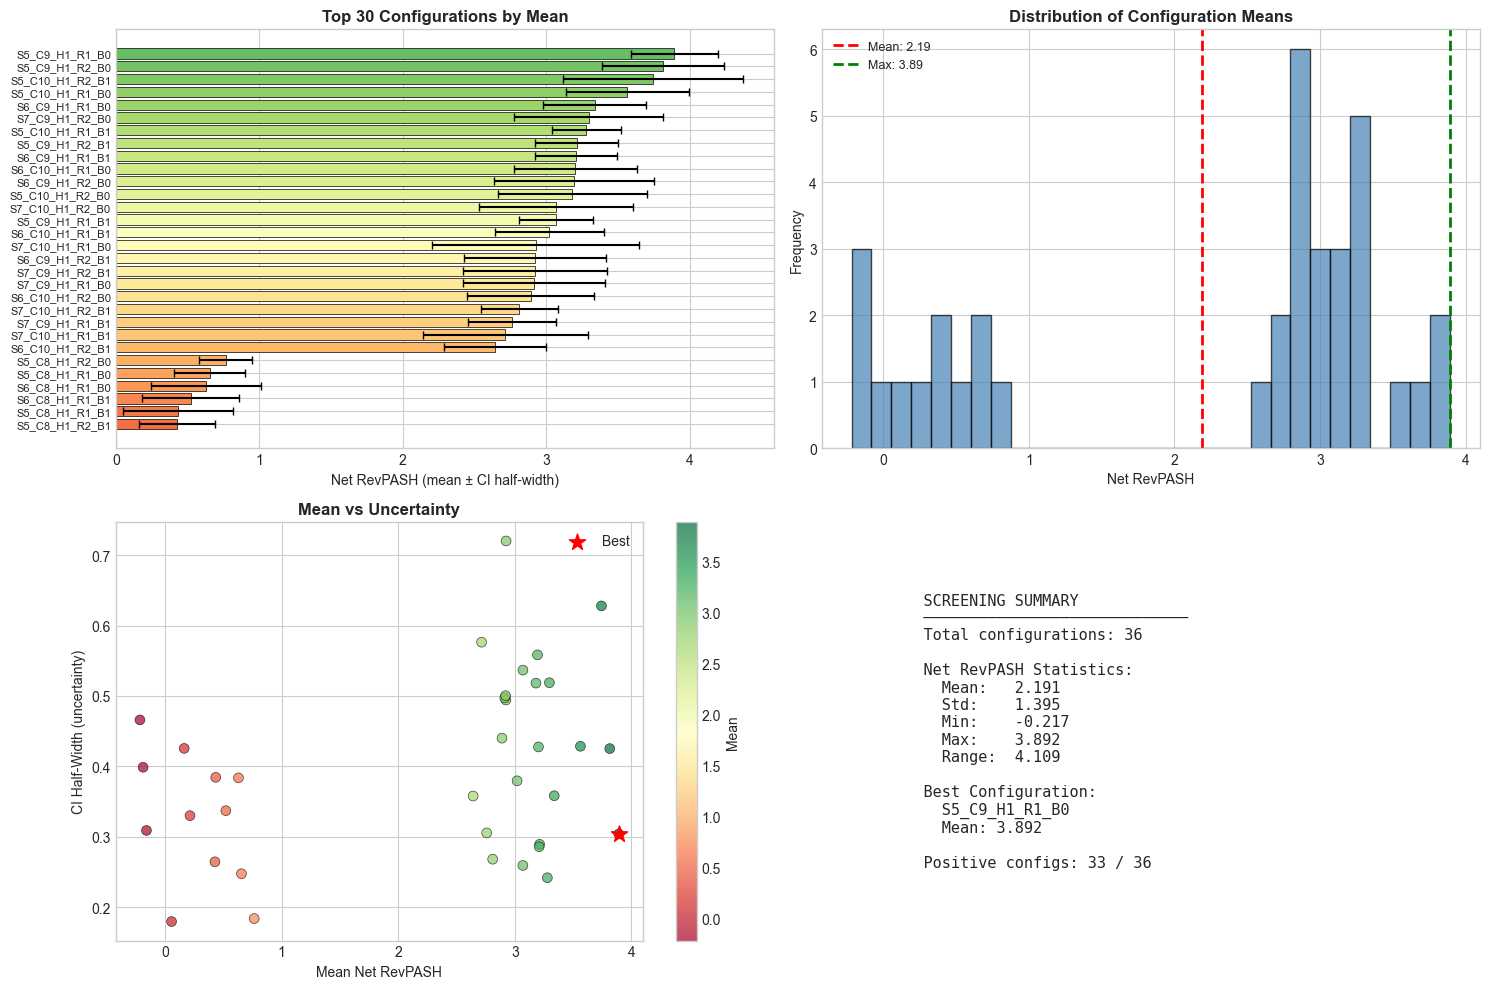

In [32]:
# Visualize screening results
plot_screening_results(screening_results, top_n=30)


In [33]:
# =============================================================================
# STEP 3: Apply Subset Selection (Bonferroni Correction)
# =============================================================================
print("STEP 3: Subset Selection")
print("=" * 70)

# Apply screening to identify promising configurations
selection = subset_selection(screening_results, confidence=0.95)

# Show which configs survived screening
print("\nPromising configurations (may be best):")
for idx in selection['may_be_best']:
    label = config_to_label(screening_results[idx]['config'])
    mean = screening_results[idx]['ci']['mean']
    print(f"  Config {idx}: {label} (mean={mean:.3f})")
print()


STEP 3: Subset Selection
Subset Selection Results (Bonferroni-corrected, α/35):
  Sample best: Config 4 (mean=3.892)
  May be best: 11 configs ([4, 6, 11, 8, 16, 30, 20, 18, 10, 34, 32])
  Not best: 25 configs (screened out)

Promising configurations (may be best):
  Config 4: S5_C9_H1_R1_B0 (mean=3.892)
  Config 6: S5_C9_H1_R2_B0 (mean=3.814)
  Config 11: S5_C10_H1_R2_B1 (mean=3.743)
  Config 8: S5_C10_H1_R1_B0 (mean=3.563)
  Config 16: S6_C9_H1_R1_B0 (mean=3.338)
  Config 30: S7_C9_H1_R2_B0 (mean=3.296)
  Config 20: S6_C10_H1_R1_B0 (mean=3.202)
  Config 18: S6_C9_H1_R2_B0 (mean=3.194)
  Config 10: S5_C10_H1_R2_B0 (mean=3.181)
  Config 34: S7_C10_H1_R2_B0 (mean=3.069)
  Config 32: S7_C10_H1_R1_B0 (mean=2.925)



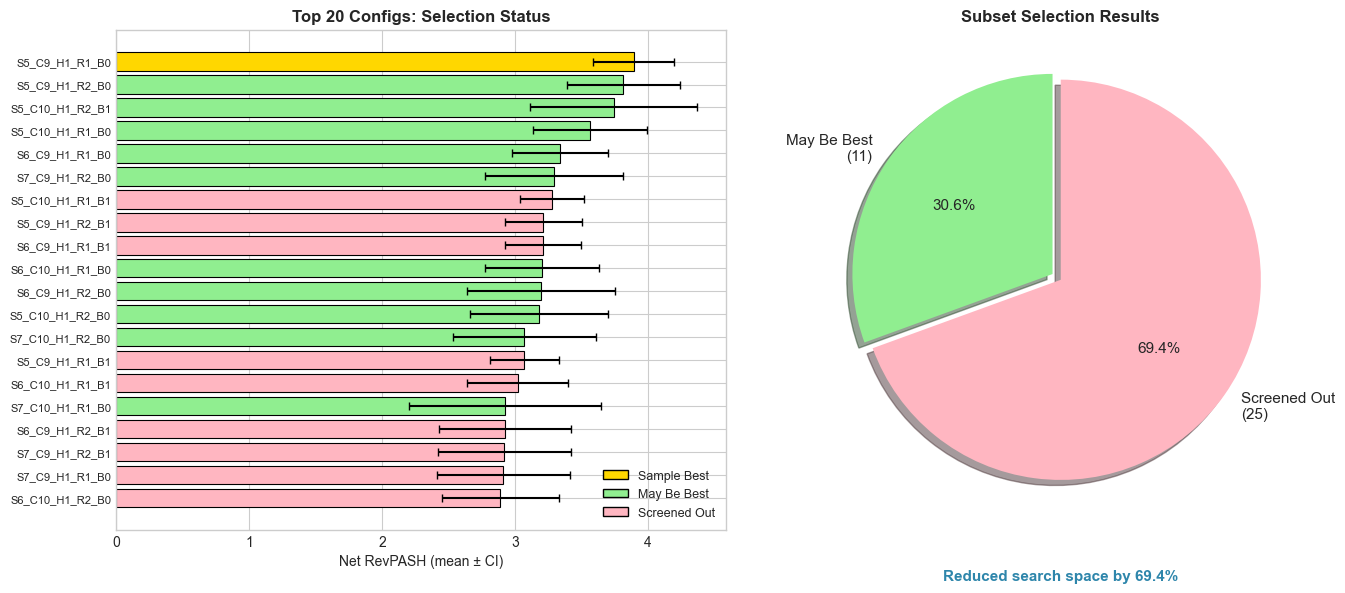

In [34]:
# Visualize subset selection results
plot_subset_selection(screening_results, selection, top_n_display=20)


In [35]:
# =============================================================================
# STEP 4: Full Precision Study on Promising Configs
# =============================================================================
print("STEP 4: Full Precision Study (target: 5% relative error)")
print("=" * 70)

# Only run full precision study on configs that may be the best
final_results = {}

for idx in selection['may_be_best']:
    config = screening_results[idx]['config']
    pilot_samples = screening_results[idx]['samples']
    label = config_to_label(config)
    
    print(f"\nConfig {idx} ({label}):")
    
    # Run to target precision, starting from screening samples
    result = run_to_target_precision(
        params=config,
        pilot_samples=pilot_samples,
        metric='net_revpash',
        target_relative_error=0.05,
        confidence=0.95,
        base_seed=1000 + idx * 1000,  # Same seed range as screening
        max_iterations=5
    )
    
    final_results[idx] = result
    print(f"  Final: mean={result['ci']['mean']:.3f}, n={len(result['all_samples'])}")

print("\n" + "=" * 70)
print("Full precision study complete.")
print()


STEP 4: Full Precision Study (target: 5% relative error)

Config 4 (S5_C9_H1_R1_B0):
Running to target precision: 5.0% relative error
Starting with 10 pilot samples
Iteration 1: n=10, mean=3.89, rel_error=7.81%
  Estimated n_required: 21, running 11 more replications...
Iteration 2: n=21, mean=3.81, rel_error=4.59%
✓ Target achieved! Relative error ≤ 5.0%
  Final: mean=3.814, n=21

Config 6 (S5_C9_H1_R2_B0):
Running to target precision: 5.0% relative error
Starting with 10 pilot samples
Iteration 1: n=10, mean=3.81, rel_error=11.15%
  Estimated n_required: 40, running 30 more replications...
Iteration 2: n=40, mean=3.50, rel_error=5.25%
  Estimated n_required: 44, running 10 more replications...
Iteration 3: n=50, mean=3.46, rel_error=4.86%
✓ Target achieved! Relative error ≤ 5.0%
  Final: mean=3.455, n=50

Config 11 (S5_C10_H1_R2_B1):
Running to target precision: 5.0% relative error
Starting with 10 pilot samples
Iteration 1: n=10, mean=3.74, rel_error=16.78%
  Estimated n_required: 8

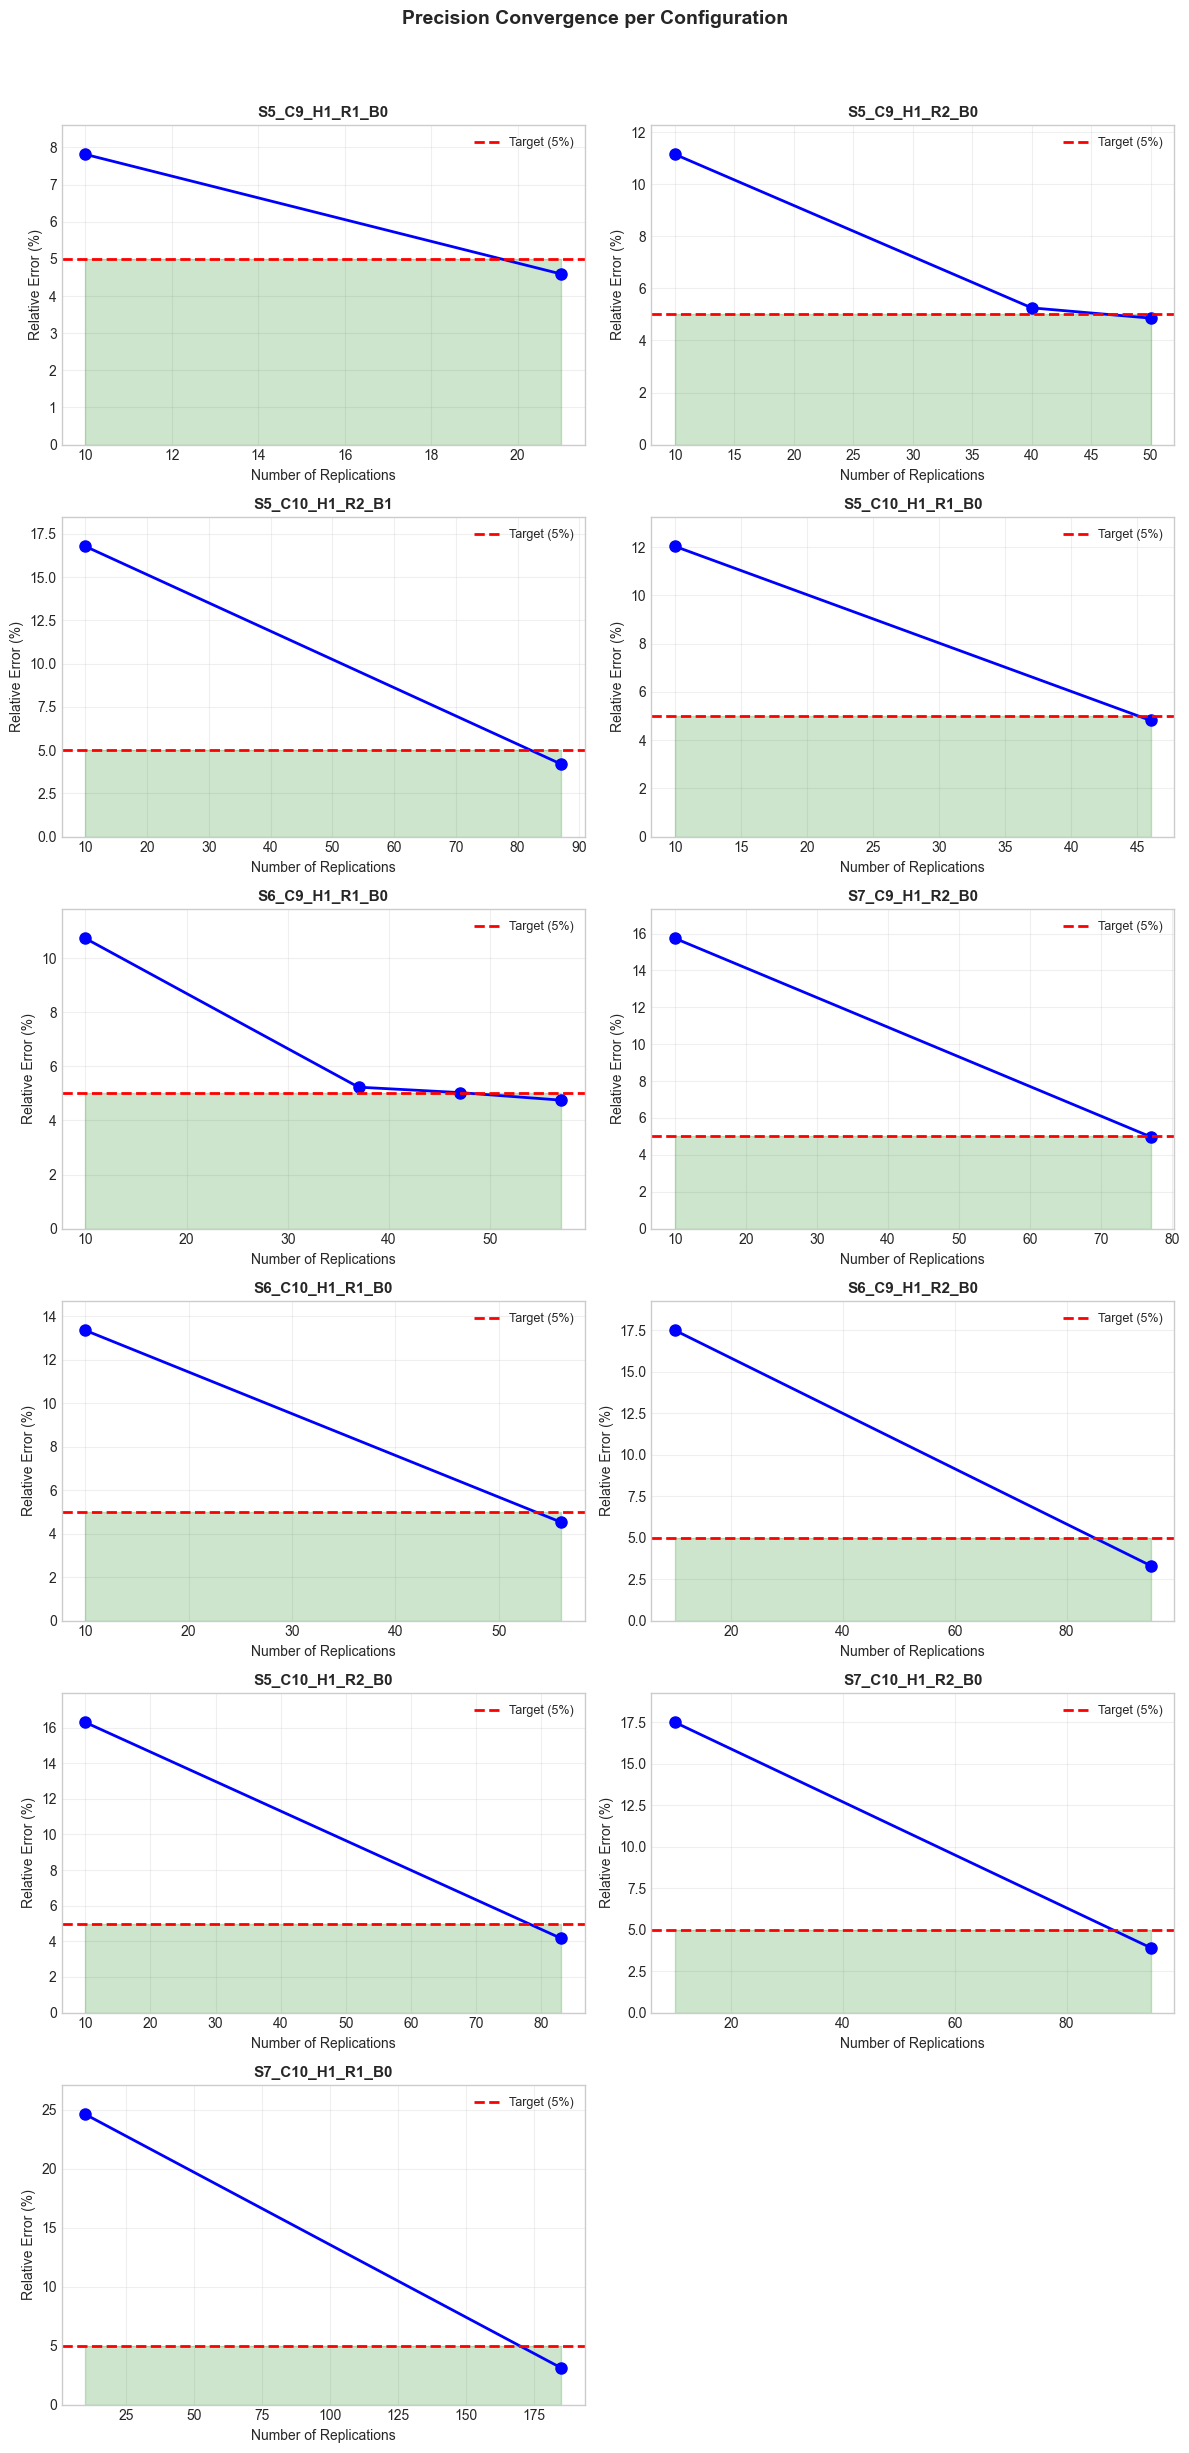

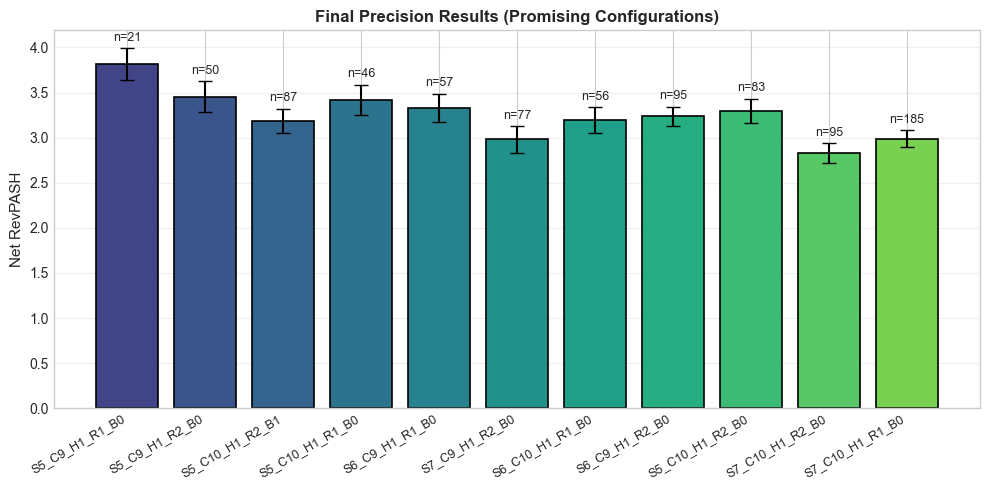

In [40]:
# Visualize precision convergence and final results
plot_precision_convergence(final_results, screening_results)


In [41]:
# =============================================================================
# STEP 5: Pairwise Comparison of Top Candidates
# =============================================================================
print("STEP 5: Pairwise Comparison (CI for Differences)")
print("=" * 70)

# Rank configs by mean (highest first)
ranked_configs = sorted(
    final_results.keys(),
    key=lambda i: final_results[i]['ci']['mean'],
    reverse=True
)

print("\nFinal Rankings (by net_revpash):")
for rank, idx in enumerate(ranked_configs, 1):
    ci = final_results[idx]['ci']
    label = config_to_label(screening_results[idx]['config'])
    print(f"  {rank}. Config {idx} ({label}): {ci['mean']:.3f} "
          f"[{ci['ci_lower']:.3f}, {ci['ci_upper']:.3f}]")

# Pairwise comparisons between adjacent ranks
print("\nPairwise Comparisons (CI for A - B):")
print("-" * 70)

for i in range(min(3, len(ranked_configs) - 1)):  # Compare top 3 pairs
    idx_A = ranked_configs[i]
    idx_B = ranked_configs[i + 1]
    
    label_A = config_to_label(screening_results[idx_A]['config'])
    label_B = config_to_label(screening_results[idx_B]['config'])
    
    comparison = compare_configurations_pairwise(
        final_results[idx_A]['all_samples'],
        final_results[idx_B]['all_samples'],
        confidence=0.95
    )
    
    print(f"\n{label_A} vs {label_B}:")
    print(f"  Mean A: {comparison['mean_A']:.3f}, Mean B: {comparison['mean_B']:.3f}")
    print(f"  Difference (A - B): {comparison['mean_diff']:.3f}")
    print(f"  95% CI: [{comparison['ci_lower']:.3f}, {comparison['ci_upper']:.3f}]")
    
    if comparison['significant']:
        if comparison['A_better']:
            print(f"  Result: A is SIGNIFICANTLY BETTER than B ✓")
        else:
            print(f"  Result: B is SIGNIFICANTLY BETTER than A ✓")
    else:
        print(f"  Result: No significant difference (CI contains 0)")

print("\n" + "=" * 70)
print("Analysis complete!")


STEP 5: Pairwise Comparison (CI for Differences)

Final Rankings (by net_revpash):
  1. Config 4 (S5_C9_H1_R1_B0): 3.814 [3.639, 3.989]
  2. Config 6 (S5_C9_H1_R2_B0): 3.455 [3.287, 3.623]
  3. Config 8 (S5_C10_H1_R1_B0): 3.419 [3.255, 3.584]
  4. Config 16 (S6_C9_H1_R1_B0): 3.330 [3.172, 3.489]
  5. Config 10 (S5_C10_H1_R2_B0): 3.296 [3.159, 3.434]
  6. Config 18 (S6_C9_H1_R2_B0): 3.235 [3.128, 3.342]
  7. Config 20 (S6_C10_H1_R1_B0): 3.194 [3.049, 3.338]
  8. Config 11 (S5_C10_H1_R2_B1): 3.187 [3.053, 3.320]
  9. Config 32 (S7_C10_H1_R1_B0): 2.986 [2.893, 3.080]
  10. Config 30 (S7_C9_H1_R2_B0): 2.980 [2.832, 3.129]
  11. Config 34 (S7_C10_H1_R2_B0): 2.827 [2.716, 2.937]

Pairwise Comparisons (CI for A - B):
----------------------------------------------------------------------

S5_C9_H1_R1_B0 vs S5_C9_H1_R2_B0:
  Mean A: 3.814, Mean B: 3.455
  Difference (A - B): 0.359
  95% CI: [0.122, 0.596]
  Result: A is SIGNIFICANTLY BETTER than B ✓

S5_C9_H1_R2_B0 vs S5_C10_H1_R1_B0:
  Mean A:

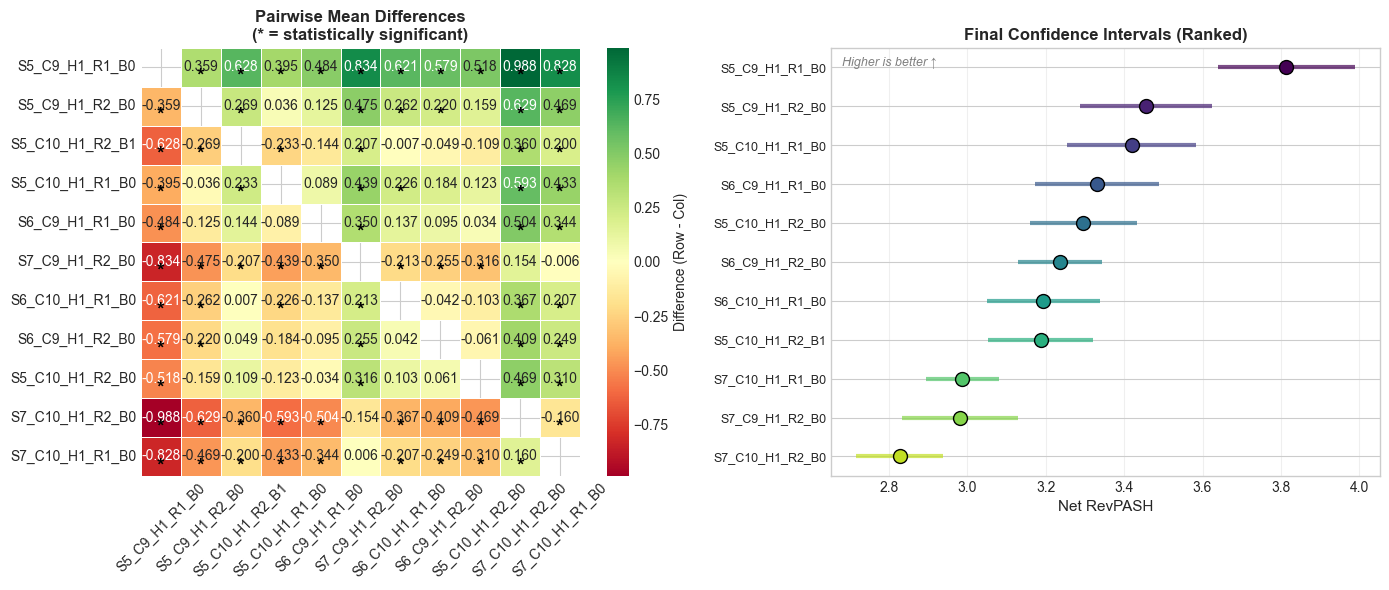


Pairwise Comparison Summary:
Best configuration: S5_C9_H1_R1_B0
Mean: 3.814

Significant differences found: 37 pairs


In [42]:
# Visualize pairwise comparisons
plot_pairwise_comparisons(final_results, screening_results, confidence=0.95)
